# Kalorimetrie Küchentischversuch - Wärmekapazität eines Behälters

Author: Maximilian Groß

Datum: 16.11.2023

Gruppe: 87

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu diesem Versuch.

Wie unterscheiden sich die Wärmekapazität einer Tasse und der hier verwendeten Schale?

## Versuchsaufbau und Durchführung

Beschreiben Sie den Versuchsaufbau und die Versuchsdurchführung. Machen Sie ein Bild von Ihrem Aufbau und nutzen Sie dieses mit zur Beschreibung.


Zunächst wurde die Schüssel mit kaltem und eine Tasse mit warmem Wasser befüllt. Anschließend wurden die Temperatursensoren in die Behältnisse gelegt. Nach circa einer Minute wurde der Inhalt der Tasse samt Sensor in die Schüssel gekippt. Dort haben die beiden Sensoren für etwa vier weitere Minuten die Temperatur gemessen.

<img src="figures/capacity.PNG" width="800">

## Versuchsauswertung

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# If you plan to write functions in another module,
# you can use importlib.reload(module) to reload the module
# at the beginning of each cell in order to make the latest
# changes take effect without restart the kernel.
import importlib

from functions import m_json

# Use FST-Style, if you don't like it, you can safely delete this line.
plt.style.use("FST.mplstyle")


### Wärmekapazität eines Behälters

Hinweis: Nutzen Sie die Funktionen *get_ids_from_setup* und *get_json_entry* um auf Metadaten zuzugreifen. 

Sie sollten Ihr Programm zwischen TODO und DONE implementieren, und versuchen die Anweisung zu verfolgen. Das ist aber nicht erforderlich.


#### (i) Messdaten einlesen

Messdaten werden in das Notebook eingelesen.

In [2]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.
import get_directory
import os

dir_path = get_directory.get_directory()

h5_path = os.path.join(dir_path,"data\data_heat_capacity.h5")
setup_path = os.path.join(dir_path,"data\setup_heat_capacity.json")
datasheets_path = os.path.join(dir_path,"data")
probe_path = os.path.join(dir_path,"data\probe_heat_capacity.json")
# DONE #

In [3]:
# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.
# HINT: You can find information about how to access to H5 Files in the README of your Repo.
import h5py
from functions import m_json, get_id_from_setup
# Reloading module
importlib.reload(get_id_from_setup)

# Getting experimental data:
f = h5py.File(h5_path,'r')
# Getting raw data
raw_data = f['RawData']
# Storing raw datasets into list
all_data = []
for key in raw_data.keys():
    all_data.append(raw_data[key])
# Splitting list into two new lists for each sensor
sensor_1_data = all_data[0]
sensor_2_data = all_data[1]
# Storing sensor 1 timestamps and temperature
sensor_1_temps = np.array(sensor_1_data["temperature"])
sensor_1_time = np.array(sensor_1_data["timestamp"])
# Storing sensor 2 timestamps and temperature
sensor_2_temps = np.array(sensor_2_data["temperature"])
sensor_2_time = np.array(sensor_2_data["timestamp"])
# Correcting time data to start at zero
sensor_1_time = sensor_1_time-sensor_1_time[0]
sensor_2_time = sensor_2_time-sensor_2_time[0]

# Reading metadata:
metadata = m_json.get_metadata_from_setup(setup_path)
setup_id = get_id_from_setup.get_id_from_setup(setup_path)
sensor_names = []
for key in raw_data.keys():
    sensor_names.append(m_json.get_json_entry(datasheets_path,setup_id,["setup",key,'name']))
# DONE #

#### (ii) Daten ploten

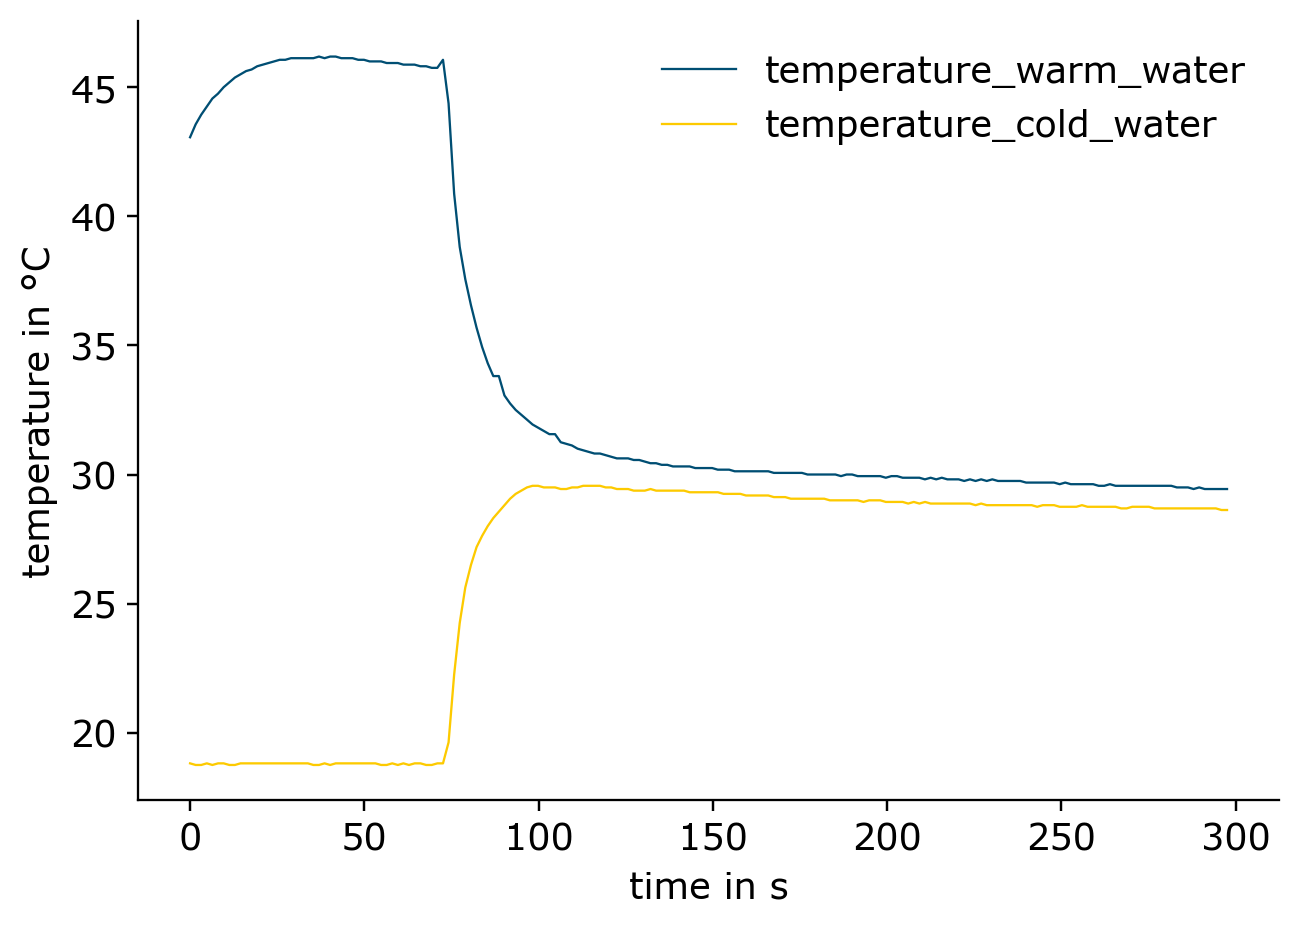

In [4]:
# TODO: Use the temperature and time data for plotting

# Plot temperature over time
plt.plot(sensor_1_time,sensor_1_temps,sensor_2_time,sensor_2_temps)
plt.ylabel('temperature in °C')
plt.xlabel('time in s')
plt.legend([sensor_names[0],sensor_names[1]])
plt.show()

# DONE #

#### (iii) Metadaten auslesen

Die notwendigen Metadaten für die Berechnung der Wärmekapazität wird ausgelesen.

In [5]:
# Heat capacity of Water
water_heat_capa = 4.18

# TODO: Read mass from the metadata of the experiment.

# Get id for json file
probe_id = get_id_from_setup.get_id_from_setup(probe_path)
# Get metadata from json file
masses = m_json.get_json_entry(datasheets_path,probe_id,['probe','metadata'])
# Store metadatat to variables
m_cup = int(masses['mass_cold_water'])
m_add = int(masses['mass_warm_water'])
# DONE #

#### (iV) Anfangs- und Endwert der Temperatur

In [6]:
# TODO: Calculation of temperature data necessary to determine the specific heat capacity

# Get t_1 and t_2 by averaging temps between 25-60
# Find out which timesteps are in between 25-60s
steps_in_between = []
for i in range(len(sensor_1_time)):
    if 25 < sensor_1_time[i] and sensor_1_time[i] < 60:
        steps_in_between.append(i)
# Add up all the temps in bewtween
x = 0
y = 0
for step in steps_in_between:
    x += sensor_1_temps[step]
    y += sensor_2_temps[step]
# Divide by number of steps to get average  
t_1 = y/len(steps_in_between)
t_2 = x/len(steps_in_between)

# Get t_M by averaging sensor temperatures in the last 10 seconds
# Find out which timesteps are in between 290-300s
steps_in_between = []
for i in range(len(sensor_1_time)):
    if 290 < sensor_1_time[i] and sensor_1_time[i] < 300:
        steps_in_between.append(i)
# Add up all the temps in bewtween
x = 0
y = 0
for step in steps_in_between:
    x += sensor_1_temps[step]
    y += sensor_2_temps[step]
# Divide by number of steps to get average  
t_1_end = y/len(steps_in_between)
t_2_end = x/len(steps_in_between)
# Add both temps together and divide by 2 to get t_M
t_M = (t_1_end+t_2_end)/2

# DONE #

#### (V) Wärmekapazität bestimmen
$$
C = \frac{m_{add}c_{w}(T_2-T_M)}{T_M - T_1} - m_{cup}c_{w}
$$
Dabei ist $m_{add}$ die Masse vom hinzugefügten Wasser, $T_2$ ist seine Temperatur. Die Masse vom Wasser im Behälter ist $m_{cup}$ und seine Temperatur ist $T_1$. Die Mischungstemperatur ist $T_M$. Die spezifische Wärmekapazität von Wasser ist $c_w$.

In [7]:
# TODO: Calculate heat capacity of the calorimeter

# Plug values in
C = m_add*water_heat_capa*(t_2-t_M)/(t_M-t_1) - m_cup*water_heat_capa

# DONE #

#### (Vi) Ergebnis

In [8]:
# TODO: Print result

print(f"Die Wärmekapazität des Behälters beträgt {round(C,2)} [J/(kg*K)] ")

# DONE #

Die Wärmekapazität des Behälters beträgt 358.19 [J/(kg*K)] 


## Diskussion

Analysieren Sie Ihre Ergebnisse aus wissenschaflticher Sicht. Berücksichtigen Sie dabei Ihre oben genannte Forschungsfrage.

Die spezifische Wärmekapazität der hier verwendeten Schale beträgt $356.58 \frac{J}{kg*K}$. Die spezifische Wärmekapazität einer durchschnittlichen Porzelantasse beträgt ca. $800 \frac{J}{kg*K}$
Die Kapaziät der Schale ist also weniger als halb so groß, obwohl diese auch aus Porzellan ist. Das könnte den Grund haben, dass die Wandstärke der Schale im Vergleich zu einer Tasse deutlich kleiner ist. Da hier ja aber die spezifische Wärmekapazität bestimmt werden sollte, sollte dies eigentlich keinen Einfluss haben. Der Grund für die Abweichung zwischen den Werten ist vermutlich ein Wärmeverlust, der beim Umschütten sowie in der Zeit der Messung danach geschehen ist. Gerade die Schüssel mit ihrer großen Durchschnittsfläche ist dafür anfällig.

## Fazit
Ziehe Sie ein persönliches Fazit zum Versuch.

Der Versuch war unterhaltsam und das Ergebniss scheint zumindest annähernd realistisch.
